# (공부) hf – lesson2:

최규빈  
2024-07-09

In [22]:
#!pip install torchtext 
#!pip install portalocker
#!pip install accelerate -U
#!pip install torchdata

In [23]:
import torchtext.datasets

In [24]:
train_iter = torchtext.datasets.IMDB(split='train')
test_iter = torchtext.datasets.IMDB(split='test')

In [25]:
# 런타임 약 30초 소요
# 출력 결과를 고정하기 위해 random.seed 도입
import random
random.seed(6)

# train_iter를 리스트 타입으로 변경
train_lists = list(train_iter)
test_lists = list(test_iter)

# 각기 1000개씩 랜덤 샘플링
train_lists_small = random.sample(train_lists, 1000)
test_lists_small = random.sample(test_lists, 1000)

# 각 변수에 담긴 인덱스 0에 해당하는 원소, 즉 첫번째 원소 출력
print(train_lists_small[0])
print(test_lists_small[0])


(2, "I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.")
(1, 'This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Tru

In [28]:
# train_texts와 train_labels라는 컨테이너 생성
# 아래 반복분에서 생성된 결과를 담는 그릇으로서 역할 수행
train_texts = []
train_labels = []

# for 반복문
# train_lists_small에 담긴 튜플 쌍 원소를 변수명 label과 text를 부여하여 순서대로 추출
for label, text in train_lists_small:
  # IMDB 데이터의 기존 레이블 2를 1로 변경, 기존 레이블 1을 0으로 변경
  train_labels.append(1 if label == 2 else 0)
  train_texts.append(text)

# text_texts와 test_labels라는 컨테이너 생성
test_texts = []
test_labels = []

# for 반복문
for label, text in test_lists_small:
  # IMDB 데이터의 기존 레이블 2를 1로 변경, 기존 레이블 1을 0으로 변경
  test_labels.append(1 if label == 2 else 0)
  test_texts.append(text)

# 각 변수에 담긴 인덱스 0에 해당하는 원소, 즉 첫번째 원소 출력
print(train_texts[0])
print(train_labels[0])
print(test_texts[0])
print(test_labels[0])


I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.
1
This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Truly a horri

In [32]:
#!pip install scikit-learn

In [33]:
# train_test_split 결과를 고정하기 위해 random_state 지정
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,
                                                                    random_state=3)
print(len(train_texts))
print(len(train_labels))
print(len(val_texts))
print(len(val_labels))


800
800
200
200

In [34]:
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/huggingface_hub-0.23.4-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

In [35]:
# 토크나이징을 통한 인코딩
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# # 0번째 입력문(텍스트)의 5번째 토큰까지의 input_ids 출력
print(train_encodings["input_ids"][0][:5])

# 위의 결과를 디코딩하여 출력
print(tokenizer.decode(train_encodings["input_ids"][0][:5]))


[101, 4937, 11350, 2038, 2048]
[CLS] cat soup has two

In [56]:
# Dataset 클래스를 상속하는 IMDBDataset 클래스를 정의
class IMDbDataset(torch.utils.data.Dataset):

    # 생성자 __init__()
    # 자신을 가르키는 매개변수 self 포함
    # 변수를 저장하기 위해 self.변수명을 사용
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # 자신을 가르키는 매개변수 self 포함
    def __getitem__(self, idx):
        # self.encoding에 담긴 키(key)와 키값(value)을 items()로 추출
        # 이 값을 key와 val 변수에 담아 새로운 키(key)와 키값(torch.tensor(val[idx]))를 갖는 딕셔너리 생성
        # 딕셔너리는 {"key1:value1", "key2:value2", ,,,} 형태를 지닌 파이썬 데이터 구조
        # val[idx]에 담긴 데이터를 torch.tensor()를 통해 파이토치 텐서로 변환
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # self.lables[idx]에 담긴 데이터를 torch.tensor()를 통해 파이토치 텐서 변환
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    # 자신을 가르키는 매개변수 self 포함
    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)


In [57]:
for i in train_dataset:
  print(i)
  break


{'input_ids': tensor([  101,  4937, 11350,  2038,  2048,  1000,  7592, 14433,  1000,  1011,
         2828, 18401,  2015, 28866,  2075,  2006,  1037, 13576,  4440,  2083,
         1996, 25115,  1010,  2073,  2505,  2064,  4148,  1010,  1998,  2515,
         1012,  2023,  2568,  1011,  4440,  4691,  4004,  2460,  3594,  2053,
        13764,  8649,  1010,  4942, 21532,  2773, 22163,  2612,  1012,  2045,
         2003,  2053,  2126,  1997,  7851,  2023, 17183, 14088,  9476,  3272,
         2000,  2425,  2017,  2000,  2156,  2009,  2005,  4426,  1012,  1998,
         2191,  2469,  2053,  2028,  2104,  2184,  2003,  1999,  1996,  2282,
         1012,  4487,  6491,  6633,  5677,  3672,  1998,  2064,  3490, 10264,
         2964,  1998, 18186,  1998,  9576,  2854,  1998,  5573,  2331,  1998,
         2655,  3560, 27770,  2005,  2500,  2024,  2691,  6991,  1012,  7481,
         1012,  3383,  1996,  2087, 13432,  3746,  2003,  2008,  1997,  2019,
        10777,  3605,  1997,  2300,  2008,  1996, 

In [58]:
# distilbert 모델 불러오기
model = transformers.DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model = model.to("cuda")


/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/huggingface_hub-0.23.4-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [59]:
training_args = transformers.TrainingArguments(
    output_dir='./results',          # 출력 디렉토리 경로
    num_train_epochs=8,              # 학습 에포크 수
    per_device_train_batch_size=16,  # 학습시 (디바이스 별) 미니 배치 수
    per_device_eval_batch_size=64,   # 평가시 (디바이스 별) 미니 배치 수
    warmup_steps=500,                # 학습률 스케줄링용 웜업 스텝 수

    weight_decay=0.01,               # 가중치 감쇄 강도
    logging_dir='./logs',            # 로그 디렉토리 경로
    logging_steps=10,
)

In [60]:
# 파인튜닝 이전에 세 입력 문장 극성 판별
# 이는 한국어판을 취해 추가된 코드임
input_tokens = tokenizer(["I feel fantastic", "My life is going something wrong", "I have not figured out what the chosen title has to do with the movie."], truncation=True, padding=True)

# 입력 문장 토크나이징 결과(input_tokens)에 담긴 input_ids를 모델에 투입
# 그리고 모델 출력 결과를 GPU로 전송하며 값은 변수 outputs에 저장
outputs = model(torch.tensor(input_tokens['input_ids']).to("cuda:0"))

# 레이블 딕셔너리 생성
label_dict = {1:'positive', 0:'negative'}

# outputs 변수에 담긴 logits 값을 행 단위, 즉 입력 문장 단위로 가장 큰 값 위치(인덱스) 추출
# 그 결과값(인덱스)을 cpu로 넘기고 넘파이 타입으로 변경 후, 인덱스에 매칭되는 레이블 출력
print([label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()])

['negative', 'negative', 'positive']

In [61]:
# 런타임 약 4 혹은 5분 소요
# 딥러닝 모델의 특성상 결과가 매번 약간 다르게 나올 수 있슴
trainer = transformers.Trainer(
    model=model,                      # 사전학습 모델 인스턴스화
    args=training_args,               # TrainingArguments에 정의한 하이퍼 파라미터값 가져오기
    train_dataset=train_dataset,      # 학습 데이터세트
    eval_dataset=val_dataset          # evaluation 데이터세트
)

trainer.train()


/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(

TrainOutput(global_step=400, training_loss=0.2804846516996622, metrics={'train_runtime': 67.5767, 'train_samples_per_second': 94.707, 'train_steps_per_second': 5.919, 'total_flos': 847791351398400.0, 'train_loss': 0.2804846516996622, 'epoch': 8.0})

In [63]:
# Trainer.train()에 의한 파인튜팅 이후 세 입력 문장 극성 판별
input_tokens = tokenizer(["I feel fantastic", "My life is going something wrong", "I have not figured out what the chosen title has to do with the movie."], truncation=True, padding=True)
outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
# 영어 원문의 1과 0값과 달리 일반적인 용례에 따라 변경
label_dict = {1:'positive', 0:'negative'}
print([label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()])

['positive', 'negative', 'negative']

In [64]:
# 문제14에서 언급한 Trainer.train( ) 방식의 성과지표로서의 정확도를 여기서 구함
# 모델 14의 주 10번 참조
# 모델을 eval 모드로 전환
model.eval()

# 문제 14 코딩의 변수 l과 혼동을 피하기 위해 컨테이너 리스트 l2 생성
l2 = []

# 반복 루프
for test_text in test_texts:

  # 토크나이징을 통한 인코딩
  input_tokens = tokenizer([test_text], truncation=True, padding=True)

  # 모델을 사용한 추론
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

  # outputs에 담긴 logits값을 기준으로 행 단위로, 즉 입력 문장 단위로 가장 큰 logits값의 인덱스를 출력 후
  # item( )을 사용하여 결과물 텐서를 CPU로 전송
  # 이렇게 처리된 값을 입력문장별로 append( )를 통해 컨테이너 리스트 l에 하나씩 저장
  l2.append(torch.argmax(outputs['logits'], axis=1).item())

# 변수 correct_cnt 초기값을 0으로 설정
correct_cnt = 0

# 리스트 l과 test_labels를 zip( )을 통해 쌍(pair)으로 묶은 후 각기 pred와 ans라는 변수로 추출
# zip()안의 데이터 쌍이 소진될 때까지 if문을 반복하여 계속 실행
for pred, ans in zip(l2, test_labels):
  if pred == ans:
    correct_cnt += 1

# 정확도(accuracy) 계산
# 딥러닝 모델의 특성상 실행시마다 성과지표가 약간 다르게 산출될 수 있음
# correct_cnt는 pred와 ans가 일치하는 건수의 총합
# test_labels는 레이블 개수의 총합, 즉 입력 문장 전체 건수
print(correct_cnt/len(test_labels))

0.876

In [65]:
# test_inference 함수 생성
def test_inference(model, tokenizer):
  input_tokens = tokenizer(["I feel fantastic", "My life is going something wrong", "I have not figured out what the chosen title has to do with the movie."], truncation=True, padding=True)
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
  # 영어 원문의 1과 0값 배정고 달리 일반적인 용례에 따라 변경
  label_dict = {1:'positive', 0:'negative'}
  return [label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()]

In [66]:
# 런타임 5분 30초 소요
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast

#１） 사전학습 모델과 토크나이저 불러오기
#    그리고 모델 실행결과에 to(devic) 코드 추가(가능한 경우 결과를 GPU에 전달)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

# 파인튜닝 이전 모델을 사용하여 test_inference 함수 실행
print(test_inference(model, tokenizer))

#２）DataLoader 인스턴스화
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

#３）최적화 함수 정의
optim = AdamW(model.parameters(), lr=5e-5)

#４）모델을 학습(train) 모드로 전환
#   이는 드롭아웃 및 배치 정규화에 영향을 미침
model.train()

losses = []

#５）에포크 횟수(epochs)만큼 루프 반복
for epoch in range(8):
    print(f'epoch:{epoch}')
    for batch in train_loader:
        #６）최적화 함수의 기울기(그래디언트) 초기화
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #７） 모델을 사용한 추론
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #８） 손실 계산
        loss = outputs[0]
        losses.append(loss)
        #９） 오차역전파
        loss.backward()
        #１０） 가중치(weight) 업데이트
        optim.step()

# 모델을 eval 모드로 전환
model.eval()

# eval 모드를 사용하여 test_inference 함수 실행
print(test_inference(model, tokenizer))


/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/huggingface_hub-0.23.4-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

['positive', 'positive', 'positive']
epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
['positive', 'negative', 'positive']

In [69]:
#!pip install matplotlib 

In [71]:
# # 다음은 에러가 발생하는 코드임에 주의
# # 이를 수정하기 위해 몇 개의 코드를 아래에 추가함
# import matplotlib.pyplot as plt
# plt.plot(losses)
# plt.show()


In [72]:
print(losses)
type(losses)

[tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7232, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7984, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7530, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6722, device='

list

In [73]:
# 파이토치에서 item( )은 텐서에서 값을 파이썬 숫자로 추출하여 CPU로 전달
new_losses = [i.item() for i in losses]

# 처음 5개 값 출력
new_losses[:5]

[0.6896294951438904,
 0.6742584705352783,
 0.7231898307800293,
 0.6434592604637146,
 0.7984352707862854]

In [74]:
# 마지막 5개 값 출력
new_losses[-5:]

[0.14343078434467316,
 0.01811479963362217,
 0.004169727675616741,
 0.002496510511264205,
 0.0032098903320729733]

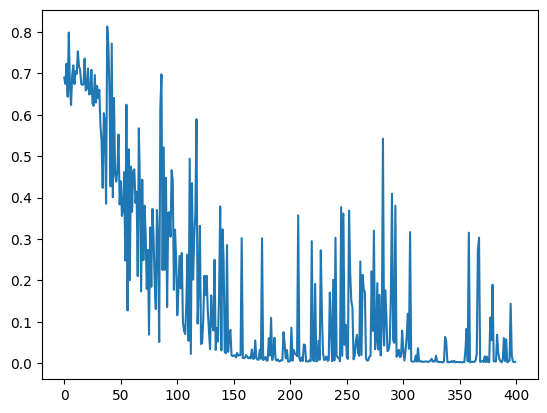

In [75]:
# matplotlib 라이브러리의 pyplot 모듈을 약칭 plt로 import
import matplotlib.pyplot as plt
plt.plot(new_losses)
plt.show();

In [76]:
# 모델을 eval 모드로 전환
model.eval()

# 변수 l이라는 컨테이너 리스트 생성
l = []

# 반복 루프
for test_text in test_texts:

  # 토크나이징을 통한 인코딩
  input_tokens = tokenizer([test_text], truncation=True, padding=True)

  # 모델을 사용한 추론
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

  # outputs에 담긴 logits값을 기준으로 행 단위로, 즉 입력 문장 단위로 가장 큰 logits값의 인덱스를 출력 후
  # item( )을 사용하여 결과물 텐서 값을 추출하고 CPU로 전송
  # 이렇게 처리된 값을 입력문장별로 append( )를 통해 컨테이너 리스트 l에 하나씩 저장
  l.append(torch.argmax(outputs['logits'], axis=1).item())

# 변수 correct_cnt 초기값을 0으로 설정
correct_cnt = 0

# 리스트 l과 test_labels를 zip( )을 통해 쌍(pair)으로 묶은 후 각기 pred와 ans라는 변수로 추출
# zip()안의 데이터 쌍이 소진될 때까지 if문을 반복하여 계속 실행
for pred, ans in zip(l, test_labels):
  if pred == ans:
    # if 조건문이 참인 경우 correct_cnt값을 1씩 증가
    correct_cnt += 1

# 정확도(accuracy) 계산
# correct_cnt는 pred와 ans가 일치하는 건수의 총합
# len(test_labels)는 레이블 개수의 총합, 즉 입력 문장 전체 건수
print(correct_cnt/len(test_labels))


0.864